# A Demo of Dimensionality Reduction Evaluation

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [22]:
plt.style.use('dark_background')

In [2]:
import plotly.express as px

In [9]:
from umap import UMAP

In [56]:
from sklearn.metrics import pairwise_distances, pairwise_distances_chunked
from joblib import Parallel, delayed
import numba
from tqdm.autonotebook import tqdm

In [57]:
def compute_ranking_matrix_parallel(D):
    """ Compute ranking matrix in parallel. Input (D) is distance matrix
    """
    # if data is small, no need for parallel
    if len(D) > 1000:
        n_jobs = -1
    else:
        n_jobs = 1
    r1 = Parallel(n_jobs, prefer="threads")(
            delayed(np.argsort)(i)
            for i in tqdm(D.T, desc = "computing rank matrix", leave=False)
        )
    r2 = Parallel(n_jobs, prefer="threads")(
            delayed(np.argsort)(i)
            for i in tqdm(r1, desc = "computing rank matrix", leave=False)
        )
    # write as a single array
    r2_array = np.zeros((len(r2), len(r2[0])), dtype='int32')
    for i, r2row in enumerate(tqdm(r2, desc="concatenating rank matrix", leave=False)):
        r2_array[i] = r2row
    return r2_array


@numba.njit(fastmath=True)
def populate_Q(Q, i, m, R1, R2):
    """ populate coranking matrix using numba for speed
    """
    for j in range(m):
        k = R1[i, j]
        l = R2[i, j]
        Q[k, l] += 1
    return Q


def iterate_compute_distances(data):
    """ Compute pairwise distance matrix iteratively, so we can see progress
    """
    n = data.shape[0]
    D = np.zeros((n, n), dtype='float32')
    col = 0
    with tqdm(desc="computing pairwise distances", leave=False) as pbar:
        for i, distances in enumerate(
                pairwise_distances_chunked(data, n_jobs=-1),
            ):
            D[col : col + len(distances)] = distances
            col += len(distances)
            if i ==0:
                pbar.total = int(n / len(distances))
            pbar.update(1)
    return D

def compute_coranking_matrix(data_ld, data_hd = None, D_hd = None):
    """ Compute the full coranking matrix
    """
   
    # compute pairwise probabilities
    if D_hd is None:
        D_hd = iterate_compute_distances(data_hd)
    
    D_ld =iterate_compute_distances(data_ld)
    n = len(D_ld)
    # compute the ranking matrix for high and low D
    rm_hd = compute_ranking_matrix_parallel(D_hd)
    rm_ld = compute_ranking_matrix_parallel(D_ld)
    
    # compute coranking matrix from_ranking matrix
    m = len(rm_hd)
    Q = np.zeros(rm_hd.shape, dtype='int16')
    for i in tqdm(range(m), desc="computing coranking matrix"):
        Q = populate_Q(Q,i, m, rm_hd, rm_ld)
        
    Q = Q[1:,1:]
    return Q


@numba.njit(fastmath=True)
def qnx_crm(crm, k):
    """ Average Normalized Agreement Between K-ary Neighborhoods (QNX)
    # QNX measures the degree to which an embedding preserves the local
    # neighborhood around each observation. For a value of K, the K closest
    # neighbors of each observation are retrieved in the input and output space.
    # For each observation, the number of shared neighbors can vary between 0
    # and K. QNX is simply the average value of the number of shared neighbors,
    # normalized by K, so that if the neighborhoods are perfectly preserved, QNX
    # is 1, and if there is no neighborhood preservation, QNX is 0.
    #
    # For a random embedding, the expected value of QNX is approximately
    # K / (N - 1) where N is the number of observations. Using RNX
    # (\code{rnx_crm}) removes this dependency on K and the number of
    # observations.
    #
    # @param crm Co-ranking matrix. Create from a pair of distance matrices with
    # \code{coranking_matrix}.
    # @param k Neighborhood size.
    # @return QNX for \code{k}.
    # @references
    # Lee, J. A., & Verleysen, M. (2009).
    # Quality assessment of dimensionality reduction: Rank-based criteria.
    # \emph{Neurocomputing}, \emph{72(7)}, 1431-1443.

    Python reimplmentation of code by jlmelville
    (https://github.com/jlmelville/quadra/blob/master/R/neighbor.R)
    """
    qnx_crm_sum = np.sum(crm[:k, :k])
    return qnx_crm_sum / (k * len(crm))

@numba.njit(fastmath=True)
def rnx_crm(crm, k):
    """ Rescaled Agreement Between K-ary Neighborhoods (RNX)
    # RNX is a scaled version of QNX which measures the agreement between two
    # embeddings in terms of the shared number of k-nearest neighbors for each
    # observation. RNX gives a value of 1 if the neighbors are all preserved
    # perfectly and a value of 0 for a random embedding.
    #
    # @param crm Co-ranking matrix. Create from a pair of distance matrices with
    # \code{coranking_matrix}.
    # @param k Neighborhood size.
    # @return RNX for \code{k}.
    # @references
    # Lee, J. A., Renard, E., Bernard, G., Dupont, P., & Verleysen, M. (2013).
    # Type 1 and 2 mixtures of Kullback-Leibler divergences as cost functions in
    # dimensionality reduction based on similarity preservation.
    # \emph{Neurocomputing}, \emph{112}, 92-108.

    Python reimplmentation of code by jlmelville
    (https://github.com/jlmelville/quadra/blob/master/R/neighbor.R)
    """
    n = len(crm)
    return ((qnx_crm(crm, k) * (n - 1)) - k) / (n - 1 - k)


#@numba.njit(fastmath=True)
def rnx_auc_crm(crm):
    """ Area Under the RNX Curve 
    # The RNX curve is formed by calculating the \code{rnx_crm} metric for
    # different sizes of neighborhood. Each value of RNX is scaled according to
    # the natural log of the neighborhood size, to give a higher weight to smaller
    # neighborhoods. An AUC of 1 indicates perfect neighborhood preservation, an
    # AUC of 0 is due to random results.
    #
    # param crm Co-ranking matrix.
    # return Area under the curve.
    # references
    # Lee, J. A., Peluffo-Ordo'nez, D. H., & Verleysen, M. (2015).
    # Multi-scale similarities in stochastic neighbour embedding: Reducing
    # dimensionality while preserving both local and global structure.
    # \emph{Neurocomputing}, \emph{169}, 246-261.

    Python reimplmentation of code by jlmelville
    (https://github.com/jlmelville/quadra/blob/master/R/neighbor.R)
    """
    n = len(crm)
    num = 0
    den = 0
    
    qnx_crm_sum = 0
    for k in tqdm(range(1, n - 2)):
        #for k in (range(1, n - 2)):
        qnx_crm_sum += np.sum(crm[(k-1), :k]) + np.sum(crm[:k, (k-1)]) - crm[(k-1), (k-1)]
        qnx_crm = qnx_crm_sum / (k * len(crm))
        rnx_crm = ((qnx_crm * (n - 1)) - k) / (n - 1 - k)
        num += rnx_crm / k
        den += 1 / k
    return num / den

First we'll need some dummy data in three dimensions to use for the demo.

In [3]:
rs = RandomState(MT19937(SeedSequence(123456789)))

In [4]:
class1 = rs.multivariate_normal(mean=[5,4,1], cov=identity(3), size=3)
class2 = rs.multivariate_normal(mean=[1,6,1], cov=identity(3), size=3)

In [5]:
dw = concatenate([absolute(class1), absolute(class2)])

In [6]:
classes = [0]*3 + [1]*3

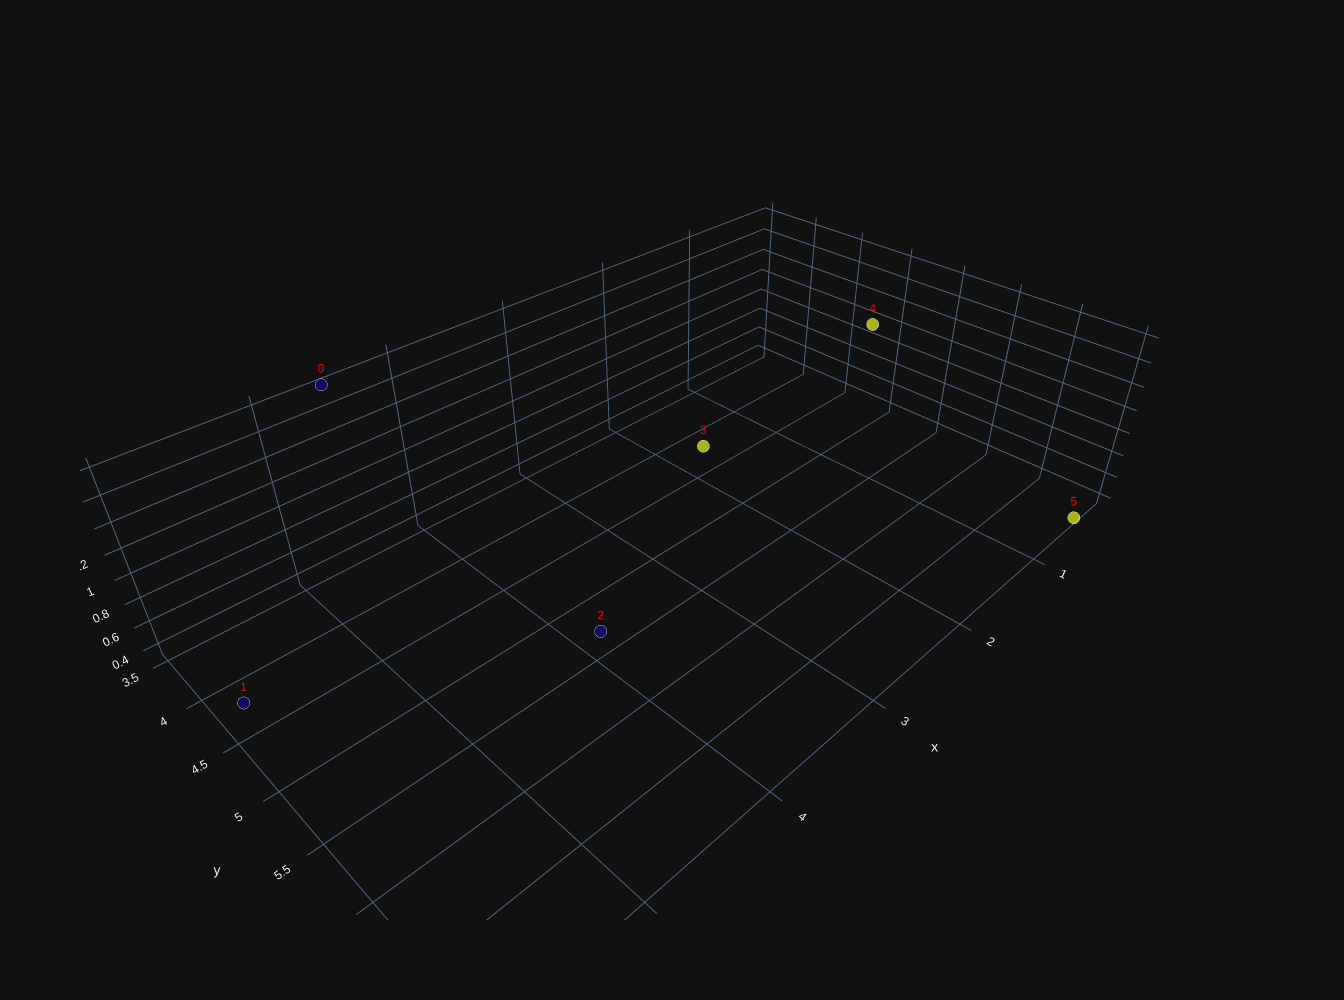

In [52]:
fig = px.scatter_3d(x=dw[:,0],y=dw[:,1],z=dw[:,2],color=classes,size=[1]*6,template="plotly_dark",text=[str(i) for i in range(6)],)
fig.update_traces(marker_coloraxis=None,textfont_color="red")
fig.update_layout(autosize=False,width=1000,height=1000)
fig.write_image(file="../IMAGES/demo_3d.png", format="png")
fig.show()

In [10]:
model_umap = UMAP(n_components=2, init='random', random_state=1)
umap_dt = model_umap.fit_transform(dw)

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning:

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



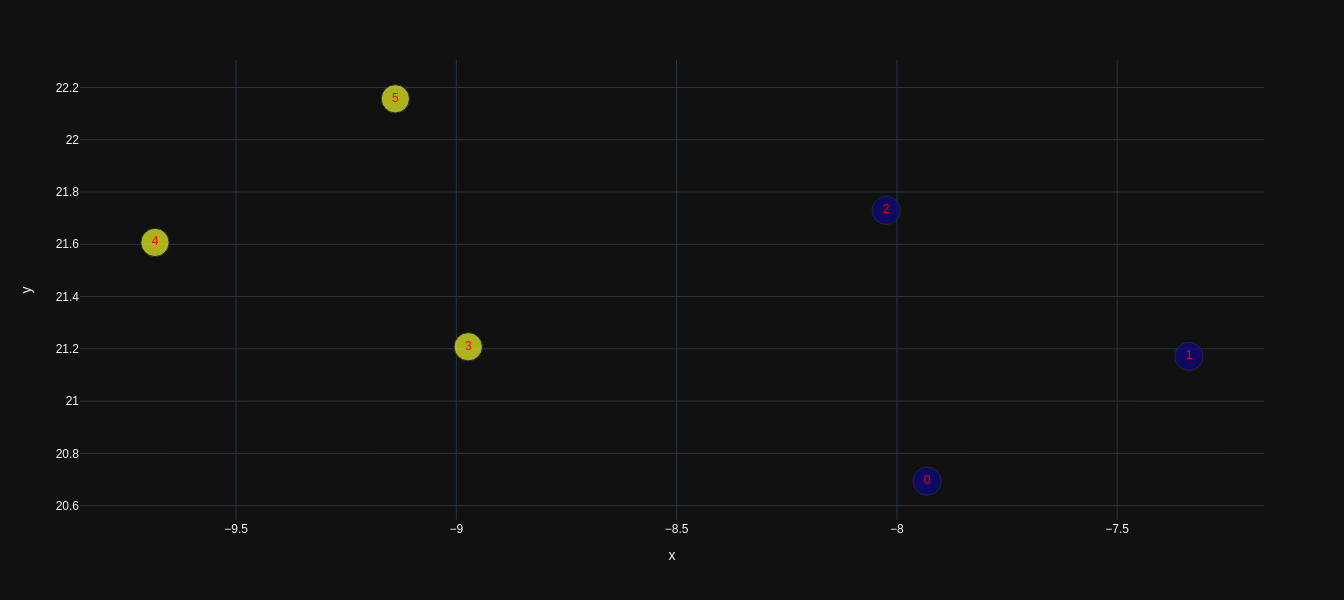

In [54]:
fig = px.scatter(x=umap_dt[:,0],y=umap_dt[:,1],color=classes,size=[1]*6,template="plotly_dark",text=[str(i) for i in range(6)],)
fig.update_traces(marker_coloraxis=None,textfont_color="red")
fig.update_layout(autosize=False,width=800,height=600)
fig.write_image(file="../IMAGES/demo_2d.png", format="png")
fig.show()

In [12]:
from scipy.spatial.distance import euclidean

In [15]:
from sklearn.metrics import pairwise_distances

In [25]:
dwd = pairwise_distances(dw)
dtd = pairwise_distances(umap_dt)

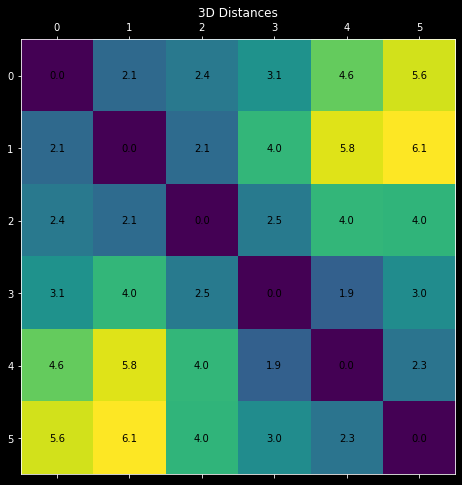

In [43]:
mat = dwd
fig,ax = subplots(nrows=1,ncols=1,figsize=(8,8))
ax.matshow(mat);
#colorbar();
for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        ax.text(i,j, round(mat[i,j],1), va='center', ha='center', color="black")
title("3D Distances");

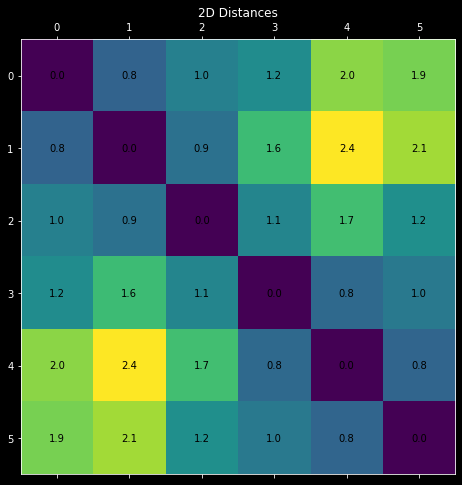

In [58]:
mat = dtd
fig,ax = subplots(nrows=1,ncols=1,figsize=(8,8))
ax.matshow(mat);
#colorbar();
for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        ax.text(i,j, round(mat[i,j],1), va='center', ha='center', color="black")
title("2D Distances");

In [65]:
R1 = compute_ranking_matrix_parallel(dwd)
R2 = compute_ranking_matrix_parallel(dtd)

computing rank matrix:   0%|          | 0/6 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/6 [00:00<?, ?it/s]

concatenating rank matrix:   0%|          | 0/6 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/6 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/6 [00:00<?, ?it/s]

concatenating rank matrix:   0%|          | 0/6 [00:00<?, ?it/s]

In [59]:
Q_umap = compute_coranking_matrix(data_ld=umap_dt, data_hd=dw)

computing pairwise distances: 0it [00:00, ?it/s]

computing pairwise distances: 0it [00:00, ?it/s]

computing rank matrix:   0%|          | 0/6 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/6 [00:00<?, ?it/s]

concatenating rank matrix:   0%|          | 0/6 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/6 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/6 [00:00<?, ?it/s]

concatenating rank matrix:   0%|          | 0/6 [00:00<?, ?it/s]

computing coranking matrix:   0%|          | 0/6 [00:00<?, ?it/s]

In [79]:
mat

array([[0, 1, 2, 3, 4, 5],
       [1, 0, 2, 3, 4, 5],
       [2, 1, 0, 3, 5, 4],
       [4, 5, 2, 0, 1, 3],
       [4, 5, 3, 1, 0, 2],
       [4, 5, 3, 2, 1, 0]], dtype=int32)

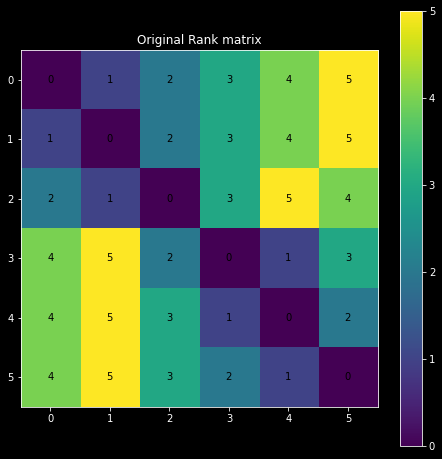

In [86]:
mat = R1
fig,ax = subplots(nrows=1,ncols=1,figsize=(8,8))
m = ax.imshow(mat,origin='upper');
colorbar(m, ax=ax);
for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        ax.text(i,j, round(mat[j,i],1), va='center', ha='center', color="black")
title("Original Rank matrix");

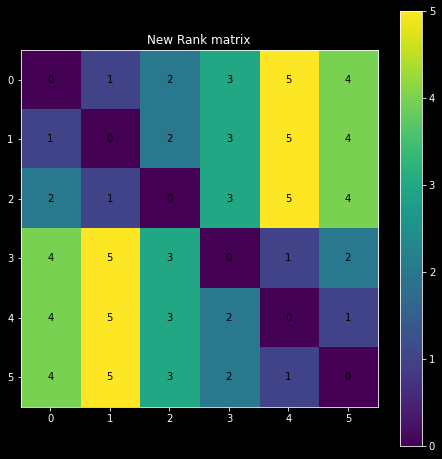

In [87]:
mat = R2
fig,ax = subplots(nrows=1,ncols=1,figsize=(8,8))
m = ax.imshow(mat,origin='upper');
colorbar(m, ax=ax);
for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        ax.text(i,j, round(mat[j,i],1), va='center', ha='center', color="black")
title("New Rank matrix");

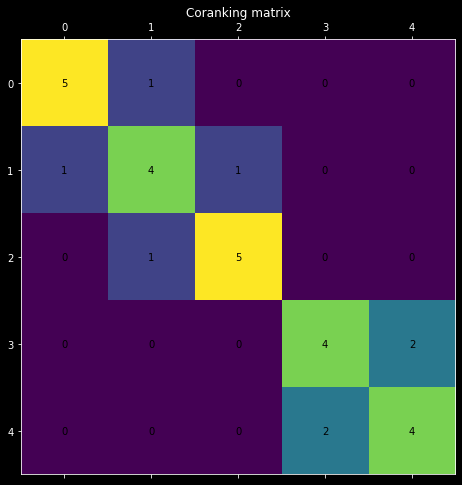

In [88]:
mat = Q_umap
fig,ax = subplots(nrows=1,ncols=1,figsize=(8,8))
ax.matshow(mat);
#colorbar();
for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        ax.text(i,j, round(mat[j,i],1), va='center', ha='center', color="black")
title("Coranking matrix");